In [9]:
import sklearn
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold,train_test_split,cross_val_score,cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)
pd.options.display.max_rows = 10

In [10]:
df = pd.read_csv('5gr_content_3.csv', sep=';')
df = df.dropna(subset=['text']).drop_duplicates()
df

,group_url,text,comments,likes,reposts
0,samsung.galaxy_a,"Как сделать, чтобы эта ***** пришла на телефон?",1,0,0
1,samsung.galaxy_a,Сегодня скачал обновление (к сожалению не андр...,9,0,0
3,samsung.galaxy_a,Купил а71. Наушники в комплекте не о чем. За к...,14,1,0
4,samsung.galaxy_a,Как убрать пиратский баннер на весь экран в бр...,13,0,0
5,samsung.galaxy_a,Характеристики Snapdragon 875 и предполагаемые...,0,3,0
...,...,...,...,...,...
27551,ru_oppo,Специалисты ресурса gizmochina решили проверит...,0,2,0
27552,ru_oppo,OPPO брат естественных условиях,1,2,0
27553,ru_oppo,Представители компании Oppo вчера сообщили о т...,0,2,0
27554,ru_oppo,Сегодня компания Oppo заявила о 3 млн смартфон...,0,0,0


In [11]:
import re
from nltk.stem.snowball import SnowballStemmer

def cleaning_data(code_data):
    text = code_data
    text = text.replace('(<br/>)', '')
    text = text.replace('(<a).*(>).*(</a>)', '')
    text = text.replace('(&amp)', '')
    text = text.replace('(&gt)', '')
    text = text.replace('(&lt)', '')
    text = text.replace('(\xa0)', ' ')
    text = filtering(text)
    #text = stemmering(text)
    return text.strip()

def filtering(text):
    stripped = re.sub('[^a-zA-Z, ^А-Я,а-я]', ' ', str(text).replace('-', ''))
    stripped = re.sub('_', '', stripped)
    stripped = re.sub('\s+', ' ', stripped)
    return str(stripped).lower()

def stemmering(text):
    stemmer = SnowballStemmer("russian")
    return ' '.join([stemmer.stem(word) for word in text.split(' ')])

In [12]:
X, y = [' '.join(df[df.group_url == i].text) for i in df.group_url.drop_duplicates()], [i for i in df.group_url.drop_duplicates()]
print(len(X))

5


In [20]:
X, y = df.text, df.group_url

In [21]:
X = pd.DataFrame(list(map(cleaning_data, X)))[0]

In [22]:
y = y[(X != ' ').values]
X = X[(X != ' ').values]

In [23]:
y = y[X.apply(lambda x: len(x.split(' ')) > 10 and len(x.split(' ')) < 500).values]
X = X[X.apply(lambda x: len(x.split(' ')) > 10 and len(x.split(' ')) < 500).values]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(len(X_train))
print(len(X_test))

14203
3551


In [25]:
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(lowercase=True)
x_train_tf = vectorizer.fit_transform(X_train)
x_test_tf = vectorizer.transform(X_test)
print(x_train_tf.shape)

(14203, 36169)


In [26]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):
    df = pd.DataFrame(classificationReport).T.iloc[:,:3]
    df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])
    return df

In [27]:
model = LogisticRegression()
model.fit(x_train_tf.toarray(), y_train)

predictions = model.predict(x_test_tf.toarray())

c:\users\yelzha\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


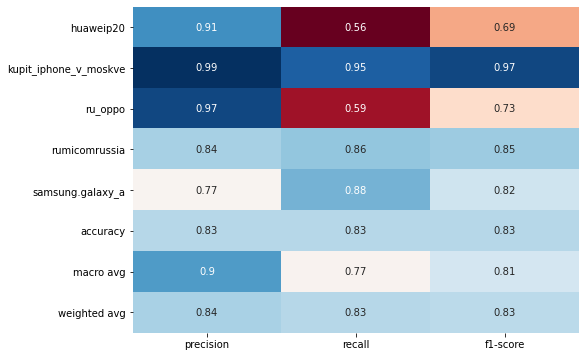

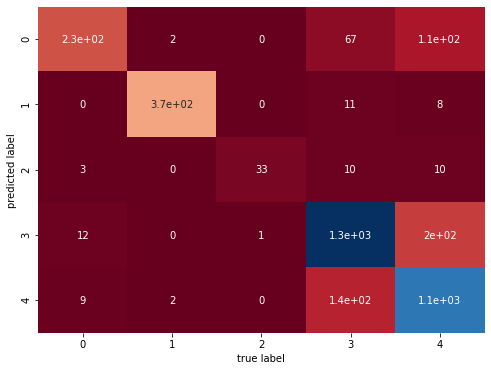

In [28]:
sns.heatmap(plot_classification_report(classification_report(y_test, predictions, output_dict=True)),
            square=False, annot=True, cmap='RdBu', cbar=False)
plt.show()

sns.heatmap(confusion_matrix(y_test, predictions), square=False, annot=True, cmap='RdBu', cbar=False)

plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [32]:
X

0    как сделать, чтобы эта пришла на телефон сегод...
1    apple lightning и адаптер оригинал цена за каб...
2    узнал недавно, что есть фотоаппарат xiaomi yi ...
3    всем привет ребята предлагают обмен на huawei ...
4    ранее компания oppo объявляла о том, что oppo ...
Name: 0, dtype: object

In [33]:
from nltk.corpus import stopwords

count = CountVectorizer(lowercase=True, stop_words=stopwords.words('russian'))
count_matrix = count.fit_transform(X)

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

print(count_matrix.shape)

(5, 43110)


In [37]:
cosine_sim

array([[1.        , 0.19077046, 0.52191505, 0.50605958, 0.1637008 ],
       [0.19077046, 1.        , 0.15866243, 0.14051192, 0.08315115],
       [0.52191505, 0.15866243, 1.        , 0.47150962, 0.21319301],
       [0.50605958, 0.14051192, 0.47150962, 1.        , 0.15978966],
       [0.1637008 , 0.08315115, 0.21319301, 0.15978966, 1.        ]])

In [34]:
indices = pd.Series(X.index)

def recommendations(title, cosine_sim = cosine_sim):
    recommended_movies = []
    
    idx = indices[indices == title].index[0]
    
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    top_10_indexes = zip(list(score_series.iloc[0:11].index), list(score_series.iloc[0:11].values))
    
    for i, j in top_10_indexes:
        recommended_movies.append([list(X.index)[i], j])
        
    return recommended_movies

In [36]:
[print(j, X.iloc[i]) for i, j in recommendations(0, cosine_sim)]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[None, None, None, None, None]